**Ad - Soyad:** ŞÜKRÜ YAVUZ

**Numara:** 2312729015

**GitHub Repo:** https://github.com/Yavuz0707/Kimya-Tesisinde-Reaksiyon-Suresi-ve-Sicaklik-Ayari.git


### **Başlangıç Ayarları ve Kütüphane Yüklemeleri**
Bu bölüm, gerekli kütüphaneleri (numpy, matplotlib, random vb.) yükler ve grafik ayarlarını yapar. Ayrıca, Python uyarılarını gizleyerek çıktıyı daha temiz hale getirir.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
import warnings

# Uyarıları gizle ve grafik ayarlarını yap
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

### **Problem Tanımı ve Amaç Fonksiyonu**
Bu kısım, optimizasyon probleminin temelini oluşturur. Amaç fonksiyonu `y = 8x1 + 3x2 - x1x2 + x1^2` olarak tanımlanır ve `x1` (süre) ile `x2` (sıcaklık) için sınır değerleri (`BOUNDS`) belirtilir. `objective_function` ve `check_constraints` fonksiyonları, her bir çözümün uygunluğunu ve geçerliliğini değerlendirmek için kullanılır.

In [2]:
# --- KRİTER 1: PROBLEMİN TANIMI VE SENARYO UYGUNLUĞU ---
# Amaç Fonksiyonu: y = 8x1 + 3x2 - x1x2 + x1^2
# Kısıtlar: x1+x2 <= 140, x2 >= 60

BOUNDS = [(10, 60), (40, 120)] # x1: Süre, x2: Sıcaklık

def objective_function(x1, x2):
    """Senaryo 5'teki amaç fonksiyonunu hesaplar."""
    return 8*x1 + 3*x2 - (x1 * x2) + (x1**2)

def check_constraints(x1, x2):
    """Verilen kısıtların sağlanıp sağlanmadığını kontrol eder."""
    # Kısıt 1: Toplam 140'ı geçmemeli
    c1 = (x1 + x2 <= 140)
    # Kısıt 2: Sıcaklık 60'tan az olmamalı
    c2 = (x2 >= 60)

    if c1 and c2:
        return True
    return False

### **Genetik Algoritma Parametreleri ve Birey Oluşturma**
Bu bölüm, Genetik Algoritma'nın temel parametrelerini (popülasyon büyüklüğü, jenerasyon sayısı, mutasyon oranı vb.) tanımlar ve `create_individual` ile `create_population` fonksiyonları ile başlangıç popülasyonunu oluşturur.

In [3]:
# --- KRİTER 2: GENETİK ALGORİTMA YAPISI ---

POPULATION_SIZE = 50     # Popülasyon büyüklüğü
GENERATIONS = 100        # Jenerasyon sayısı
MUTATION_RATE = 0.10     # Mutasyon oranı (%10)
ELITISM_COUNT = 2        # Elitizm (En iyi kaç birey korunacak)

def create_individual():
    """Rastgele genlere sahip bir birey oluşturur."""
    x1 = random.uniform(BOUNDS[0][0], BOUNDS[0][1])
    x2 = random.uniform(BOUNDS[1][0], BOUNDS[1][1])
    return [x1, x2]

def create_population(size):
    """Başlangıç popülasyonunu oluşturur."""
    return [create_individual() for _ in range(size)]

### **Uygunluk (Fitness) Fonksiyonu**
`get_fitness` fonksiyonu, her bir bireyin amaç fonksiyonu değerini hesaplar. Kısıtları ihlal eden bireylere büyük bir ceza puanı vererek uygunluklarını düşürür.

In [4]:
def get_fitness(individual):
    """
    Uygunluk (Fitness) fonksiyonu.
    Kısıtları sağlamayan bireylere ceza puanı verilir.
    """
    x1, x2 = individual[0], individual[1]

    if check_constraints(x1, x2):
        return objective_function(x1, x2)
    else:
        return -999999 # Ceza Puanı (Penalty)

### **Seçim (Selection) Fonksiyonu**
`selection` fonksiyonu, turnuva seçimi yöntemini kullanarak popülasyondan sonraki jenerasyon için ebeveyn adaylarını seçer. Rastgele seçilen bireyler arasından en yüksek uygunluğa sahip olanı döndürür.

In [5]:
def selection(population):
    """
    Turnuva Seçimi (Tournament Selection).
    Rastgele 3 birey seçip en iyisini döndürür.
    """
    tournament = random.sample(population, 3)
    tournament.sort(key=get_fitness, reverse=True)
    return tournament[0]

### **Çaprazlama (Crossover) Fonksiyonu**
`crossover` fonksiyonu, iki ebeveynin genlerini birleştirerek iki yeni çocuk birey oluşturur. Burada aritmetik çaprazlama yöntemi kullanılır, yani genlerin ağırlıklı ortalaması alınır.

In [6]:
def crossover(parent1, parent2):
    """
    Aritmetik Çaprazlama (Arithmetic Crossover).
    Ebeveynlerin genlerinin ağırlıklı ortalamasını alır.
    """
    alpha = random.random()
    # Çocuk 1
    c1_x1 = alpha * parent1[0] + (1 - alpha) * parent2[0]
    c1_x2 = alpha * parent1[1] + (1 - alpha) * parent2[1]

    # Çocuk 2
    c2_x1 = (1 - alpha) * parent1[0] + alpha * parent2[0]
    c2_x2 = (1 - alpha) * parent1[1] + alpha * parent2[1]

    return [c1_x1, c1_x2], [c2_x1, c2_x2]

### **Mutasyon (Mutation) Fonksiyonu**
`mutate` fonksiyonu, belirli bir `MUTATION_RATE` olasılığıyla bir bireyin genlerinden birini rastgele yeni bir değerle değiştirir. Bu, çeşitliliği korumaya ve yerel optimumlardan kaçınmaya yardımcı olur.

In [7]:
def mutate(individual):
    """
    Mutasyon Fonksiyonu.
    Belirli bir olasılıkla gen değerini rastgele değiştirir.
    """
    if random.random() < MUTATION_RATE:
        gene_idx = random.randint(0, 1) # x1 veya x2'yi seç
        individual[gene_idx] = random.uniform(BOUNDS[gene_idx][0], BOUNDS[gene_idx][1])
    return individual

### **Genetik Algoritmanın Ana Döngüsü**
Bu bölüm, Genetik Algoritma'nın çekirdeğini oluşturan ana döngüyü içerir. Belirlenen jenerasyon sayısı boyunca popülasyonu evrimleştirir. Her jenerasyonda:
1.  Popülasyon uygunluğa göre sıralanır.
2.  En iyi birey ve uygunluğu kaydedilir.
3.  Elitizm uygulanarak en iyi bireyler yeni popülasyona doğrudan aktarılır.
4.  Geri kalan popülasyon, seçim, çaprazlama ve mutasyon operasyonları ile oluşturulur.

Bu döngü sonunda en iyi çözüm ve maksimum verim bulunur.

In [8]:
# --- GENETİK DÖNGÜ (Main Loop) ---
print("Genetik Algoritma Başlatılıyor...")

population = create_population(POPULATION_SIZE)
best_fitness_history = []
best_solution = None
global_max_fitness = -float('inf')

for gen in range(GENERATIONS):
    # 1. Mevcut popülasyonu fitness'a göre sırala (En iyi en üstte)
    population.sort(key=get_fitness, reverse=True)

    # 2. En iyi bireyi kaydet
    current_best = population[0]
    current_fitness = get_fitness(current_best)

    if current_fitness > global_max_fitness:
        global_max_fitness = current_fitness
        best_solution = current_best[:]

    best_fitness_history.append(current_fitness)

    # 3. Yeni jenerasyon oluştur
    new_population = []

    # Elitizm: En iyileri doğrudan aktar
    new_population.extend(population[:ELITISM_COUNT])

    # Geri kalanı üret (Seçim -> Çaprazlama -> Mutasyon)
    while len(new_population) < POPULATION_SIZE:
        p1 = selection(population)
        p2 = selection(population)

        c1, c2 = crossover(p1, p2)

        new_population.append(mutate(c1))
        if len(new_population) < POPULATION_SIZE:
            new_population.append(mutate(c2))

    population = new_population

print("\n--- OPTİMİZASYON TAMAMLANDI ---")
print(f"Optimal x1 (Süre)    : {best_solution[0]:.4f} dk")
print(f"Optimal x2 (Sıcaklık): {best_solution[1]:.4f} °C")
print(f"Maksimum Verim (y)   : {global_max_fitness:.4f}")

Genetik Algoritma Başlatılıyor...

--- OPTİMİZASYON TAMAMLANDI ---
Optimal x1 (Süre)    : 59.7873 dk
Optimal x2 (Sıcaklık): 60.1239 °C
Maksimum Verim (y)   : 638.5472


### **Sonuçların Görselleştirilmesi: Yakınsama Grafiği**
Bu grafik, Genetik Algoritma'nın jenerasyonlar boyunca en iyi uygunluk değerinin nasıl geliştiğini gösterir. Algoritmanın yakınsama davranışını (yani çözüme ne kadar hızlı yaklaştığını) anlamak için kullanılır.

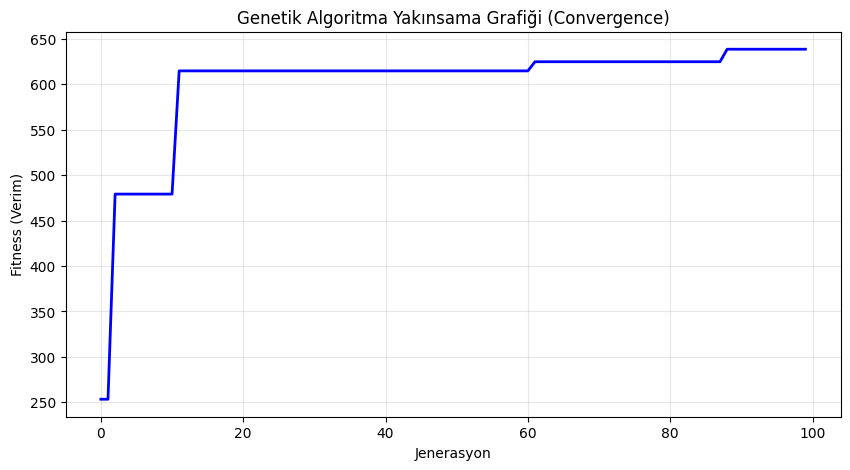

In [9]:
# Grafik 1: İlerleme Grafiği (Evolution Plot)
plt.figure(figsize=(10, 5))
plt.plot(best_fitness_history, linewidth=2, color='blue')
plt.title('Genetik Algoritma Yakınsama Grafiği (Convergence)')
plt.xlabel('Jenerasyon')
plt.ylabel('Fitness (Verim)')
plt.grid(True, alpha=0.3)
plt.show()

### **Sonuçların Görselleştirilmesi: Çözüm Uzayı ve Kısıtlar Analizi**
Bu kontur (seviye) grafiği, amaç fonksiyonunun çözüm uzayındaki dağılımını gösterir ve uygulanan kısıtların bu uzayı nasıl etkilediğini görselleştirir. Algoritma tarafından bulunan en iyi çözüm, grafikte özel bir işaretleyici ile belirtilir ve kısıt çizgileri de çizilir.

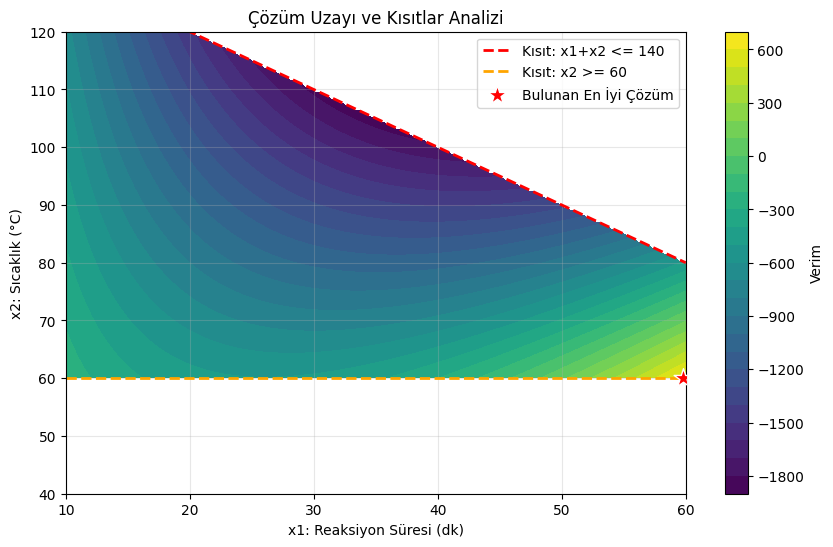

In [10]:
# Grafik 2: Kısıtlar ve Çözüm Uzayı (Contour Plot)
x1_vals = np.linspace(10, 60, 200)
x2_vals = np.linspace(40, 120, 200)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
Z = 8*X1 + 3*X2 - X1*X2 + X1**2

# Yasaklı bölgeleri maskele (x1+x2 > 140 veya x2 < 60)
mask = (X1 + X2 > 140) | (X2 < 60)
Z_masked = np.ma.array(Z, mask=mask)

plt.figure(figsize=(10, 6))
contour = plt.contourf(X1, X2, Z_masked, levels=25, cmap='viridis')
plt.colorbar(contour, label='Verim')

# Sınır çizgilerini çiz
plt.plot(x1_vals, 140 - x1_vals, 'r--', linewidth=2, label='Kısıt: x1+x2 <= 140')
plt.axhline(y=60, color='orange', linestyle='--', linewidth=2, label='Kısıt: x2 >= 60')

# En iyi çözümü işaretle
plt.scatter(best_solution[0], best_solution[1], color='red', s=200, marker='*', edgecolors='white', label='Bulunan En İyi Çözüm', zorder=5)

plt.title('Çözüm Uzayı ve Kısıtlar Analizi')
plt.xlabel('x1: Reaksiyon Süresi (dk)')
plt.ylabel('x2: Sıcaklık (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(10, 60)
plt.ylim(40, 120)
plt.show()

### **Sonuç Yorumu ve Duyarlılık Analizi**
Bu son bölüm, Genetik Algoritma'nın bulduğu optimal çözümü yorumlar ve parametrelerdeki küçük değişikliklerin (duyarlılık) verim üzerindeki etkisini analiz eder. Özellikle `x1` değişkeninin (reaksiyon süresi) önemine vurgu yapılır.

In [11]:
# --- DUYARLILIK ANALİZİ  ---
print("\n--- SONUÇ YORUMU VE DUYARLILIK ANALİZİ ---")
print("Algoritma, kısıtların izin verdiği en uç noktaya (sınıra) yaklaşmıştır.")
print("x1 (Süre) değişkeni karesel ifade (x1^2) nedeniyle verimi artırmada daha baskındır.")

# Küçük bir değişim testi
test_x1 = best_solution[0] - 5 # Süreyi 5 dk azaltırsak
if check_constraints(test_x1, best_solution[1]):
    new_yield = objective_function(test_x1, best_solution[1])
    diff = ((new_yield - global_max_fitness) / global_max_fitness) * 100
    print(f"Analiz: Reaksiyon süresi 5 dk azalırsa verim %{abs(diff):.2f} oranında düşmektedir.")
else:
    print("Analiz: Parametre değişimi kısıtları ihlal etmektedir.")


--- SONUÇ YORUMU VE DUYARLILIK ANALİZİ ---
Algoritma, kısıtların izin verdiği en uç noktaya (sınıra) yaklaşmıştır.
x1 (Süre) değişkeni karesel ifade (x1^2) nedeniyle verimi artırmada daha baskındır.
Analiz: Reaksiyon süresi 5 dk azalırsa verim %48.90 oranında düşmektedir.
